In [4]:
# import module
from pdf2image import convert_from_path


# Store Pdf with convert_from_path function
images = convert_from_path('sample.pdf')

for i in range(len(images)):
  
      # Save pages as images in the pdf
    images[i].save('page'+ str(i) +'.jpg', 'JPEG')


c:\Users\ranaa\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


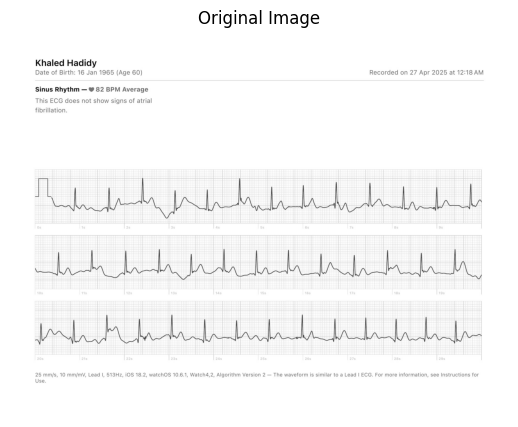

Using fixed calibration:
Horizontal: 98.50 pixels = 1 second
Vertical: 78.80 pixels = 1 mV


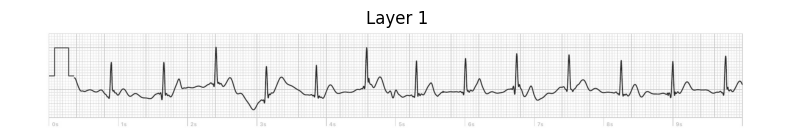

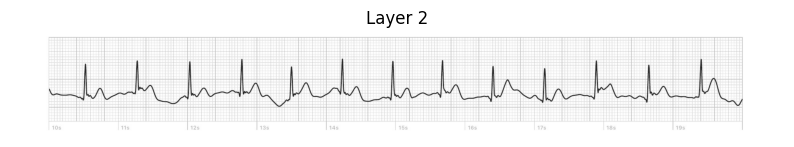

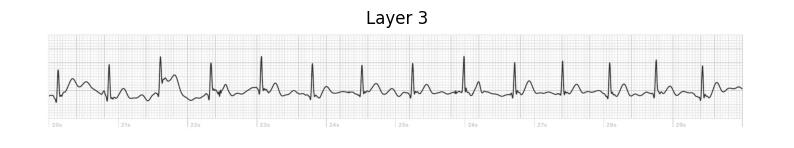

Processing Layer 1...


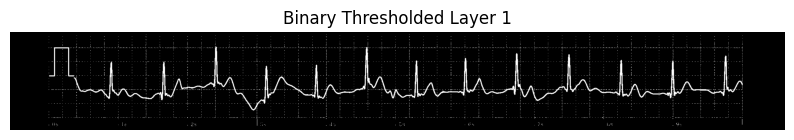

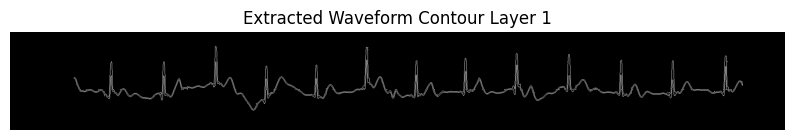

Layer 1 - Removed baseline offset of 0.10 mV


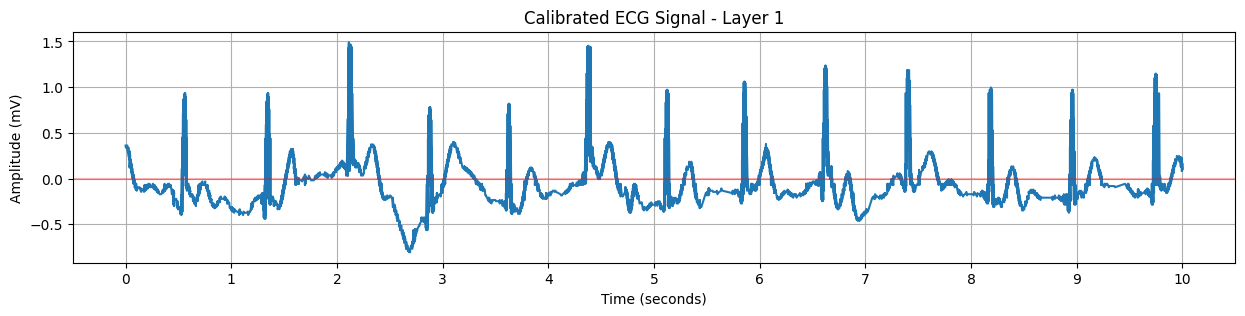

Processing Layer 2...


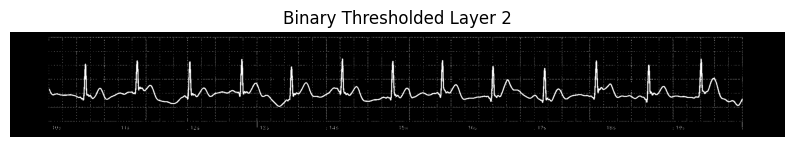

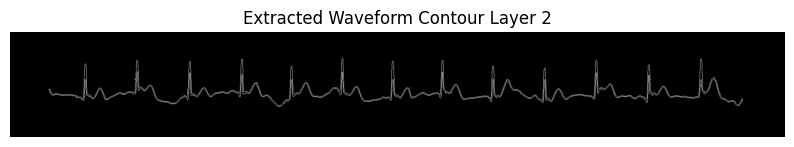

Layer 2 - Removed baseline offset of 0.12 mV


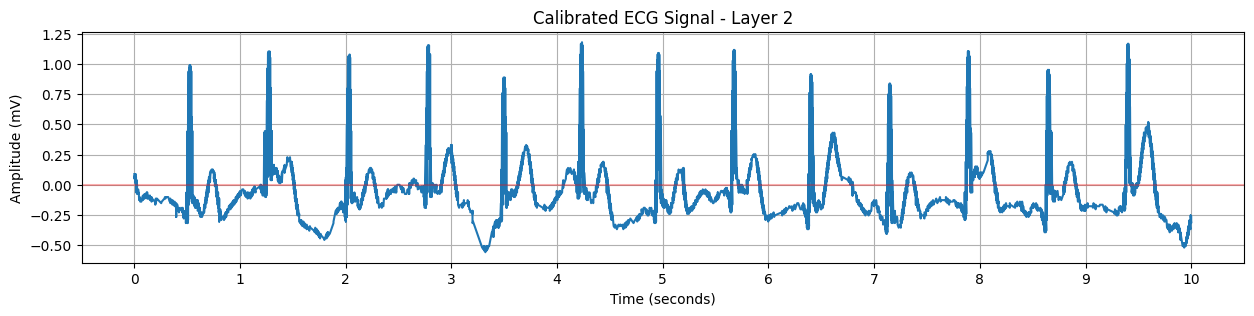

Processing Layer 3...


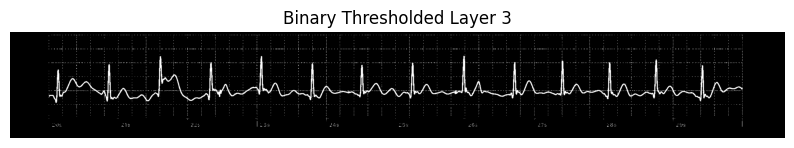

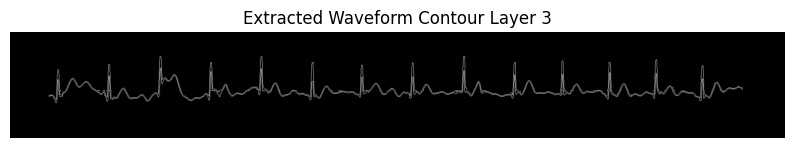

Layer 3 - Removed baseline offset of 0.24 mV


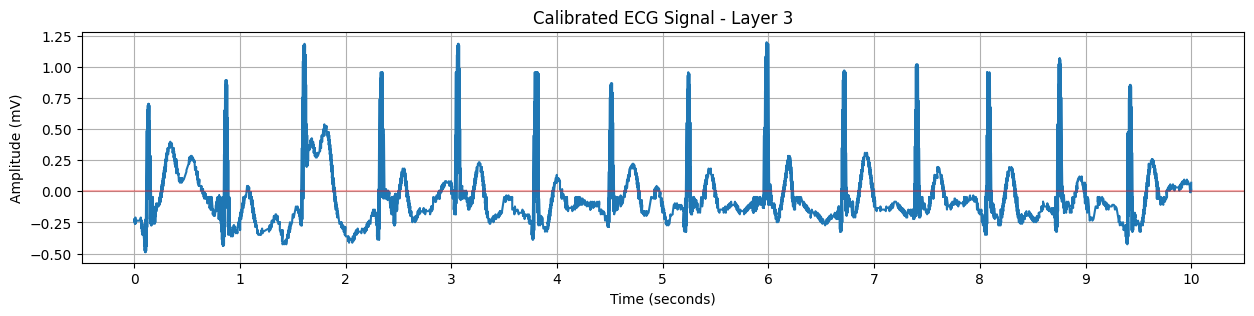

Combined signal - Removed baseline offset of -0.07 mV
Current signal peak amplitude: 1.55 mV


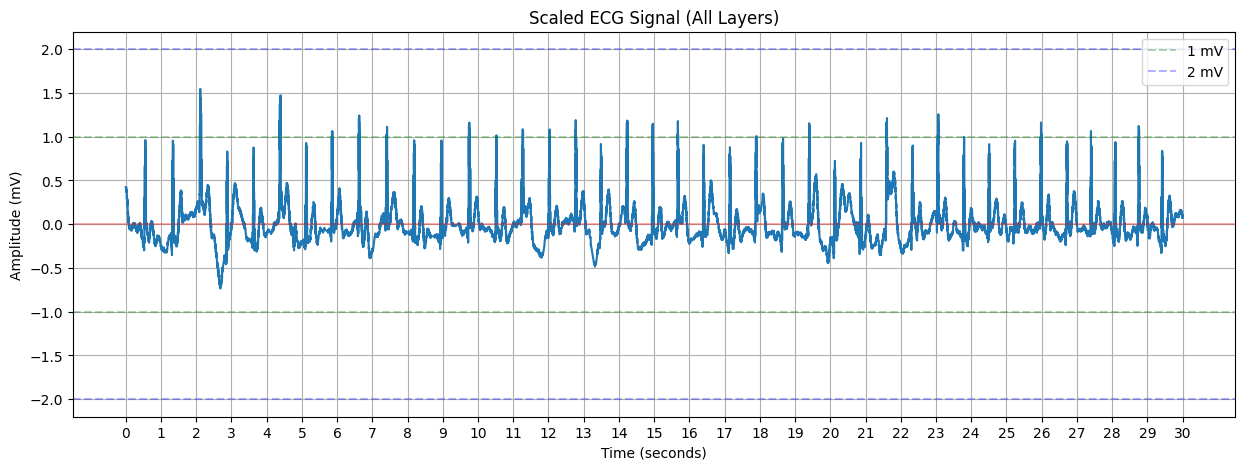

Signal saved as calibrated_ecg.dat (without header file)
Signal also saved as ecg_signal.npy


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from wfdb import wrsamp

def debug_image(image, title, cmap='gray'):
    """Displays an image for debugging purposes."""
    plt.figure(figsize=(10, 5))
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

def extract_ecg(image_path, debug=True):
    # Step 1: Load the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    height, width = img.shape

    if debug:
        debug_image(img, "Original Image")
    
    # Step 2: Fixed calibration parameters (no grid detection needed)
    # 197 pixels horizontally = 2 seconds
    # 78.8 pixels vertically = 1 mV
    calibration = {
        'seconds_per_pixel': 2.0 / 197.0,  # Convert to seconds per pixel
        'mv_per_pixel': 1.0 / 78.8,     # Convert to mV per pixel directly
    }
    
    print(f"Using fixed calibration:")
    print(f"Horizontal: {197/2:.2f} pixels = 1 second")
    print(f"Vertical: {78.8:.2f} pixels = 1 mV")

    # Step 3: Calculate pixel boundaries using percentages
    header_end = int(height * 35.29 / 100)
    layer1_start = int(height * 35.35 / 100)
    layer1_end = int(height * 51.76 / 100)
    layer2_start = int(height * 51.82 / 100)
    layer2_end = int(height * 69.41 / 100)
    layer3_start = int(height * 69.47 / 100)
    layer3_end = int(height * 87.06 / 100)

    # Crop each layer using calculated boundaries
    layers = [
        img[layer1_start:layer1_end, :],  # Layer 1
        img[layer2_start:layer2_end, :],  # Layer 2
        img[layer3_start:layer3_end, :]   # Layer 3
    ]

    if debug:
        for i, layer in enumerate(layers):
            debug_image(layer, f"Layer {i + 1}")

    # Step 4: Process each layer to extract waveform contours
    signals = []
    time_points = []
    
    # Each layer is exactly 10 seconds long
    layer_duration = 10.0  # seconds
    
    for i, layer in enumerate(layers):
        print(f"Processing Layer {i+1}...")
        
        # Binary thresholding
        _, binary = cv2.threshold(layer, 200, 255, cv2.THRESH_BINARY_INV)
        if debug:
            debug_image(binary, f"Binary Thresholded Layer {i + 1}")

        # Detect contours
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        waveform_contour = max(contours, key=cv2.contourArea)  # Assuming largest contour is the ECG

        # Create an empty image to draw the contour
        contour_image = np.zeros_like(binary)
        cv2.drawContours(contour_image, [waveform_contour], -1, (255, 255, 255), thickness=1)
        if debug:
            debug_image(contour_image, f"Extracted Waveform Contour Layer {i + 1}")

        # Sort contour points by x-coordinate to ensure correct time ordering
        sorted_contour = sorted(waveform_contour, key=lambda p: p[0][0])
        
        # Extract x and y coordinates
        x_coords = np.array([point[0][0] for point in sorted_contour])
        y_coords = np.array([point[0][1] for point in sorted_contour])
        
        # Calculate isoelectric line (one-third from the bottom of layer)
        isoelectric_line_y = layer.shape[0] * 0.6  # Two-thirds from top = one-third from bottom
        
        # Convert to time using fixed layer duration (10 seconds)
        # Rescale x coordinates to span exactly 10 seconds
        x_min, x_max = np.min(x_coords), np.max(x_coords)
        time = (x_coords - x_min) / (x_max - x_min) * layer_duration
        
        # Calculate distance from isoelectric line (positive up, negative down) and convert to millivolts
        signal_mv = (isoelectric_line_y - y_coords) * calibration['mv_per_pixel']
        
        # Baseline correction: normalize by subtracting the mean
        signal_mean = np.mean(signal_mv)
        signal_mv = signal_mv - signal_mean
        print(f"Layer {i+1} - Removed baseline offset of {signal_mean:.2f} mV")
        
        # Store the time points and calibrated signal
        time_points.append(time)
        signals.append(signal_mv)
        
        # Plot the calibrated signal for this layer
        if debug:
            plt.figure(figsize=(15, 3))
            plt.plot(time, signal_mv)
            plt.title(f"Calibrated ECG Signal - Layer {i+1}")
            plt.xlabel("Time (seconds)")
            plt.ylabel("Amplitude (mV)")
            plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)  # Add zero line
            
            # Set x-axis ticks at 1-second intervals
            plt.xticks(np.arange(0, layer_duration + 1, 1.0))
            
            plt.grid(True)
            plt.show()

    # Step 5: Combine signals from all leads with proper time alignment
    # Initialize time and signal arrays
    total_duration = layer_duration * len(layers)  # Total duration is 10 seconds per layer
    sampling_frequency = 500  # PTB-XL standard frequency
    num_samples = int(total_duration * sampling_frequency)
    combined_time = np.linspace(0, total_duration, num_samples)
    combined_signal = np.zeros(num_samples)
    
    # Place each lead at the correct time position
    for i, (time, signal) in enumerate(zip(time_points, signals)):
        # Calculate the start and end time for this layer
        start_time = i * layer_duration
        end_time = (i + 1) * layer_duration
        
        # Find the samples in combined_time that correspond to this layer
        mask = (combined_time >= start_time) & (combined_time < end_time)
        relevant_times = combined_time[mask]
        
        # Interpolate signal values onto the combined time grid
        interpolated_signal = np.interp(relevant_times, start_time + time, signal)
        
        # Place the interpolated values into the combined signal
        combined_signal[mask] = interpolated_signal
    
    # Perform baseline correction on the combined signal
    combined_signal_mean = np.mean(combined_signal)
    combined_signal = combined_signal - combined_signal_mean
    print(f"Combined signal - Removed baseline offset of {combined_signal_mean:.2f} mV")

    # Step 5.5: Apply amplitude scaling to match standard ECG range
    # Analyze the signal range
    signal_peak = np.max(np.abs(combined_signal))
    print(f"Current signal peak amplitude: {signal_peak:.2f} mV")
    
    # Calculate scaling factor to target ~2 mV peak for QRS complexes
    # This is a typical amplitude in standard ECG records
    target_amplitude = 2.0  # Target peak amplitude in mV
    
    # Only scale if our signal is significantly different from target
    if signal_peak > 0 and (signal_peak < 0.5 or signal_peak > 4.0):
        scaling_factor = target_amplitude / signal_peak
        combined_signal = combined_signal * scaling_factor
        print(f"Applied scaling factor of {scaling_factor:.2f} to match standard ECG amplitude range")

    # Plot verification of proper scaling
    if debug:
        plt.figure(figsize=(15, 5))
        plt.plot(combined_time, combined_signal)
        plt.title("Scaled ECG Signal (All Layers)")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Amplitude (mV)")
        plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)  # Zero line
        plt.axhline(y=1, color='g', linestyle='--', alpha=0.3, label='1 mV')
        plt.axhline(y=-1, color='g', linestyle='--', alpha=0.3)
        plt.axhline(y=2, color='b', linestyle='--', alpha=0.3, label='2 mV')
        plt.axhline(y=-2, color='b', linestyle='--', alpha=0.3)
        
        # Set x-axis ticks at 1-second intervals for the combined plot
        plt.xticks(np.arange(0, total_duration + 1, 1.0))
        
        plt.legend()
        plt.grid(True)
        plt.show()

    # Step 6: Save the signal as just a .dat file without .hea
    record_name = 'calibrated_ecg'
    
    # Convert signal to 16-bit integers for consistency with typical ECG format
    adc_gain = 1000.0  # Standard gain: 1000 units per mV
    int_signal = (combined_signal * adc_gain).astype(np.int16)
    
    # Save directly as binary .dat file without generating a header file
    dat_file = record_name + '.dat'
    int_signal.tofile(dat_file)
    print(f"Signal saved as {dat_file} (without header file)")
    
    # Save the signal as a numpy array for later use
    np.save('ecg_signal.npy', combined_signal)
    print(f"Signal also saved as ecg_signal.npy")
    
    return combined_time, combined_signal

# Example usage
time_points, ecg_signal = extract_ecg("page0.jpg", debug=True)

In [1]:
def digitize_ecg_from_pdf(pdf_path, output_file='calibrated_ecg.dat'):
    """
    Process an ECG PDF file and convert it to a .dat signal file.
    
    Args:
        pdf_path (str): Path to the ECG PDF file
        output_file (str): Path to save the output .dat file (default: 'calibrated_ecg.dat')
    
    Returns:
        str: Path to the created .dat file
    """
    import cv2
    import numpy as np
    from pdf2image import convert_from_path
    
    # Convert PDF to image
    images = convert_from_path(pdf_path)
    temp_image_path = 'temp_ecg_image.jpg'
    images[0].save(temp_image_path, 'JPEG')
    
    # Load the image
    img = cv2.imread(temp_image_path, cv2.IMREAD_GRAYSCALE)
    height, width = img.shape
    
    # Fixed calibration parameters
    calibration = {
        'seconds_per_pixel': 2.0 / 197.0,  # 197 pixels = 2 seconds
        'mv_per_pixel': 1.0 / 78.8,        # 78.8 pixels = 1 mV
    }
    
    # Calculate layer boundaries using percentages
    layer1_start = int(height * 35.35 / 100)
    layer1_end = int(height * 51.76 / 100)
    layer2_start = int(height * 51.82 / 100)
    layer2_end = int(height * 69.41 / 100)
    layer3_start = int(height * 69.47 / 100)
    layer3_end = int(height * 87.06 / 100)
    
    # Crop each layer
    layers = [
        img[layer1_start:layer1_end, :],  # Layer 1
        img[layer2_start:layer2_end, :],  # Layer 2
        img[layer3_start:layer3_end, :]   # Layer 3
    ]
    
    # Process each layer to extract waveform contours
    signals = []
    time_points = []
    layer_duration = 10.0  # Each layer is 10 seconds long
    
    for i, layer in enumerate(layers):
        # Binary thresholding
        _, binary = cv2.threshold(layer, 200, 255, cv2.THRESH_BINARY_INV)
        
        # Detect contours
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        waveform_contour = max(contours, key=cv2.contourArea)  # Largest contour is the ECG
        
        # Sort contour points and extract coordinates
        sorted_contour = sorted(waveform_contour, key=lambda p: p[0][0])
        x_coords = np.array([point[0][0] for point in sorted_contour])
        y_coords = np.array([point[0][1] for point in sorted_contour])
        
        # Calculate isoelectric line (one-third from the bottom)
        isoelectric_line_y = layer.shape[0] * 0.6
        
        # Convert to time using fixed layer duration
        x_min, x_max = np.min(x_coords), np.max(x_coords)
        time = (x_coords - x_min) / (x_max - x_min) * layer_duration
        
        # Calculate signal in millivolts and apply baseline correction
        signal_mv = (isoelectric_line_y - y_coords) * calibration['mv_per_pixel']
        signal_mean = np.mean(signal_mv)
        signal_mv = signal_mv - signal_mean
        
        # Store the time points and calibrated signal
        time_points.append(time)
        signals.append(signal_mv)
    
    # Combine signals with proper time alignment
    total_duration = layer_duration * len(layers)
    sampling_frequency = 500  # Standard ECG frequency
    num_samples = int(total_duration * sampling_frequency)
    combined_time = np.linspace(0, total_duration, num_samples)
    combined_signal = np.zeros(num_samples)
    
    # Place each lead at the correct time position
    for i, (time, signal) in enumerate(zip(time_points, signals)):
        start_time = i * layer_duration
        mask = (combined_time >= start_time) & (combined_time < start_time + layer_duration)
        relevant_times = combined_time[mask]
        interpolated_signal = np.interp(relevant_times, start_time + time, signal)
        combined_signal[mask] = interpolated_signal
    
    # Baseline correction and amplitude scaling
    combined_signal = combined_signal - np.mean(combined_signal)
    signal_peak = np.max(np.abs(combined_signal))
    target_amplitude = 2.0  # Target peak amplitude in mV
    
    if signal_peak > 0 and (signal_peak < 0.5 or signal_peak > 4.0):
        scaling_factor = target_amplitude / signal_peak
        combined_signal = combined_signal * scaling_factor
    
    # Convert to 16-bit integers and save as .dat file
    adc_gain = 1000.0  # Standard gain: 1000 units per mV
    int_signal = (combined_signal * adc_gain).astype(np.int16)
    int_signal.tofile(output_file)
    
    # Clean up temporary files
    import os
    if os.path.exists(temp_image_path):
        os.remove(temp_image_path)
    
    print("Complete")
    return output_file

# Example usage:
result_file = digitize_ecg_from_pdf('sample.pdf')

Complete
